In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display
from scipy.stats import mannwhitneyu, wilcoxon

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from lib.sych.data_fc_db import DataFCDatabase
from mesostat.metric.metric import MetricCalculator
from mesostat.utils.plotting import imshow

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/pub-2020-exploratory-analysis


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
# params['root_path_data']  = gui_fpath("Path to data collection",  './')
params['root_path_data'] = '/media/alyosha/Data/TE_data/yarodata/neuro'

#params['root_path_paw']   = gui_fpath("Path to Paw data",         params['root_path_data'])
#params['root_path_lick']  = gui_fpath("Path to Lick data",        params['root_path_paw'])
#params['root_path_whisk'] = gui_fpath("Path to Whisk Data",       params['root_path_lick'])
# params['root_path_te']    = gui_fpath("Select TE results folder", params['root_path_data'])

In [3]:
dataDB = DataFCDatabase(params)

Target trial within [0, 8] sec. Total target timesteps 161
Searching for channel labels
Searching for data files
No paw path provided, skipping
No lick path provided, skipping
No whisk path provided, skipping


In [4]:
dataDB.read_te_files()
dataDB.read_neuro_files()
dataDB.read_resample_paw_files()
dataDB.read_resample_lick_files()   # Currently does not work. Ask Yaro if we need it
dataDB.read_resample_whisk_files()

No TE files loaded, skipping reading part


IntProgress(value=0, description='Read Neuro Data:', max=220)

Calculated performance 0.7264150943396226 does not match external 0.7333333333333333
Calculated performance 0.803680981595092 does not match external 0.808641975308642
Calculated performance 0.8411764705882353 does not match external 0.8436578171091446
Calculated performance 0.956989247311828 does not match external 0.9621621621621622
Calculated performance 0.6808510638297872 does not match external 0.6956521739130435
Calculated performance 0.9582366589327146 does not match external 0.9604651162790697
Calculated performance 0.4851258581235698 does not match external 0.4840182648401826
--Warning: For iMISS behaviour max index 437 exceeds nTrials 437
---Cropped excessive behaviour trials from 86 to 85
Calculated performance 0.42795389048991356 does not match external 0.6902017291066282
Calculated performance 0.2534562211981567 does not match external 0.30386740331491713
Calculated performance 0.4444444444444444 does not match external 0.47227191413237923
Calculated performance 0.56680161

--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_8 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_8 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyos

In [5]:
pTHR = 0.7
dataDB.mark_days_expert_naive(pTHR)

# Mono-Regional Metrics

* Dynamic Regime
    * SNR - via AutoCorr[1]
    * Saturation regime - via phase-space scatter
    * Identify speed of evolution by estimating exp decay timescale for each dataset.
        - Find timescale that minimizes AutoCorr[1]
* Activity - Testing if one region is more active than another
    * Variance / Entropy of raw data
    * PSD
* Temporal structure
    * Individual temporal specificity (regions more active later vs earlier)
        - Test activity for each timestep vs cycle null model, plot significant bins
    * Individual temporal stability (how consistent is the activity over trials)
        - Test activity for each timestep vs cycle null model, plot -log(p) for ranksum
* Specificity to external observables (movement, action, learning)
    - Test activity for each timestep for hit/miss, (separate naive/expert)
    - Scatter temporal mean vs performance 

## 1.1 SNR via AutoCorrelation

**Plan:**
* AutoCorr[1] is a number that is close to 1 if data is changing slowly, and close to zero if data changes very fast.

doing mouse mtp_1
doing mouse mtp_10
doing mouse mtp_11
doing mouse mtp_12
doing mouse mtp_13
doing mouse mtp_15
doing mouse mtp_16
doing mouse mtp_2
doing mouse mtp_7
doing mouse mvg_2
doing mouse mvg_3
doing mouse mvg_4
doing mouse mvg_5
doing mouse mvg_6
doing mouse mvg_7
doing mouse mvg_8
doing mouse mvg_9


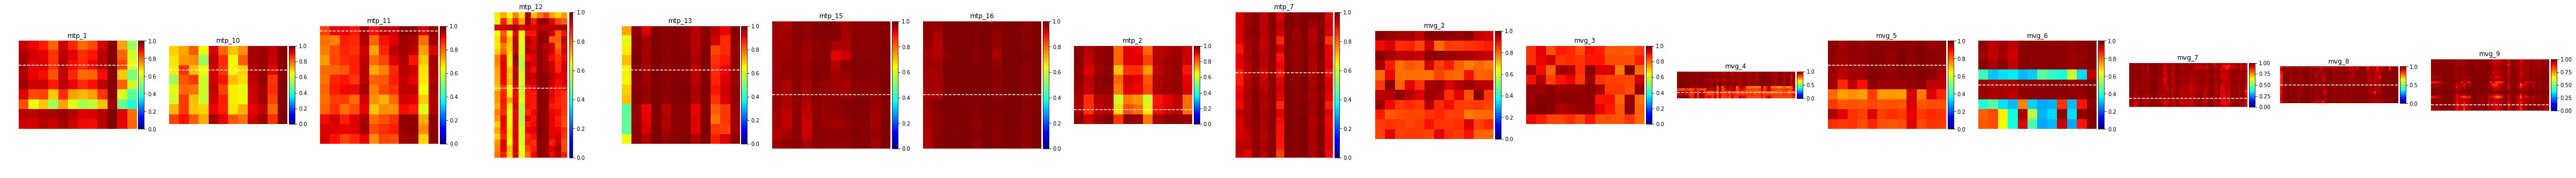

In [13]:
mc = MetricCalculator(serial=True, verbose=False)

fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(5 * len(dataDB.mice),5))
for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    print('doing mouse', mousename)
    rows = dataDB.get_rows('neuro', {'mousename' : mousename})
    
    rez = []
    rezExpert = []
    for idx, row in rows.iterrows():
        mc.set_data(dataDB.dataNeuronal[idx], 'rsp', zscoreDim=None)
        rez += [mc.metric3D('autocorr_d1', 'p', metricSettings=None, sweepSettings=None)]
        rezExpert += [dataDB.dataPerformance[idx] > 0.7]
        
    imshow(fig, ax[iMouse], np.array(rez), xlabel='sessions', ylabel='channels', title=mousename, haveColorBar=True, limits=[0,1], cmap='jet')
    
    if (len(rezExpert) > 0) and (np.any(rezExpert)):
        switchExpert = np.where(rezExpert)[0][0]
        ax[iMouse].axhline(y=switchExpert, color='w', linestyle='--')

plt.savefig('ac1.svg')
plt.show()

## 1.2 Saturation via 1-step phase space

### Idea 1: Velocity of DFF change
1. Plot $DFF(t+dt) - DFF(t)$ vs $DFF(t)$
2. Fit line, estimate tangent
3. Tangent could potentially indicate saturation, as for high and low values the jump should be strongly biased in the opposite way

**Problem**: Even for a purely random dataset, the jump at extremes is strongly biased in the opposite direction, simply because it tends towards the mean. This metric ends up being somewhat equivalent to AC(1).

**Problem2**: Since all data has at least some added noise, we will not see a sharp wall in either direction. It is unclear if data can be unambiguously separated into white noise and remainder. Thus it may be impossible to demonstrate saturation even if it exists.

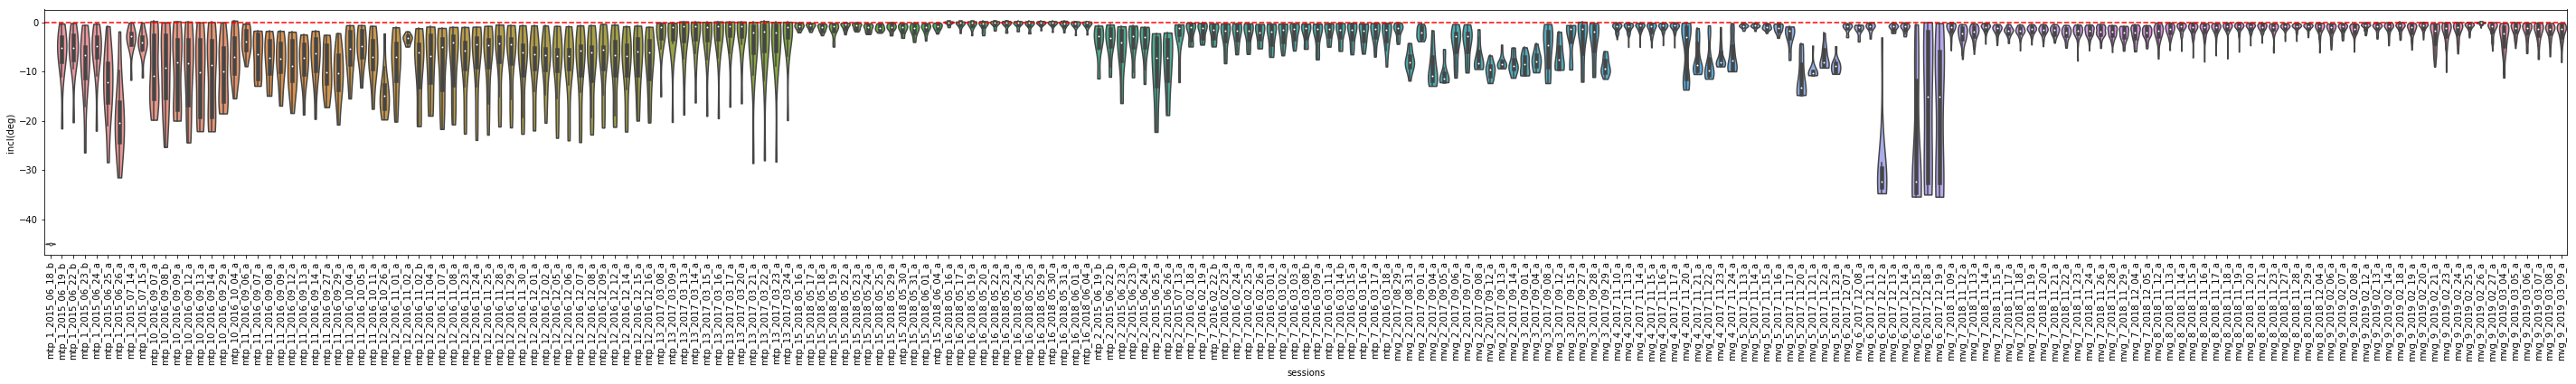

In [17]:
def dict2pandas(d, keyname, valname):
    dframes = []
    for k,v in d.items():
        dframes += [pd.DataFrame({keyname : [k] * len(v), valname : v})]
    return pd.concat(dframes)

rez = {}
for mousename in sorted(dataDB.mice):
    rows = dataDB.get_rows('neuro', {'mousename' : mousename})
    
    for idx, row in rows.iterrows(): 
        session = row['mousekey']
        data = dataDB.dataNeuronal[idx]

        rezMouse = []
        for iChannel in range(data.shape[2]):
            dataThis = data[:, :, iChannel]
            dataThis /= np.std(dataThis)
            dataPre = dataThis[:, :-1].flatten()
            dataPost = dataThis[:, 1:].flatten()

            coeff = np.polyfit(dataPre, dataPost-dataPre, 1)
            rezMouse += [np.rad2deg(np.arctan(coeff[0]))]

        rez[session] = rezMouse
    
rezDF = dict2pandas(rez, 'sessions', 'incl(deg)')

fig, ax = plt.subplots(figsize=(50,5))
sns.violinplot(data=rezDF, x='sessions', y='incl(deg)', scale='width', cut=0, axis=ax)
plt.axhline(y=0, linestyle='--', color='r')
plt.xticks(rotation=90)
plt.show()

# 2. Activity

## 2.1 Variance-based measures

mtp_1 3.9333435039614404e-05 0.015432925080058233
mtp_10 -0.0020136359234628177 0.01379268074779431
mtp_11 -0.00044086859227130125 0.016529384659067434
mtp_12 -0.0018552816919856672 0.006524315321211878
mtp_13 -0.02663014398697013 0.021256199915033202
mtp_15 -0.010154134368828272 0.03670270734152379
mtp_16 -0.00855455674217444 0.07876617430305394
mtp_2 4.9891092338899114e-05 0.007099649658798409
mtp_7 -0.0046964431487527165 0.03752901708674231
mvg_2 0.00038324570629997775 3.3215052883311893
mvg_3 6.178704043894154e-05 2.9620736252460276
mvg_4 -0.0025144711836498066 5.908898297859474
mvg_5 -0.0010443521982736632 4.0590423288223425
mvg_6 -0.006711107186070507 0.15520917516171256
mvg_7 -0.033911888775330364 0.011012878404647243
mvg_8 -0.016963723359010245 0.02526412100177458
mvg_9 -0.0028577110822176712 0.05620656848210261


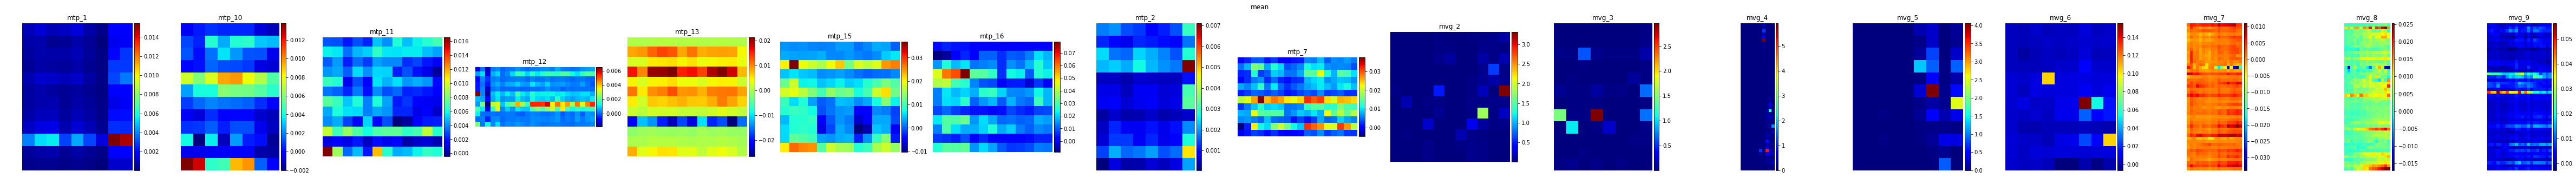

mtp_1 0.0007255937586307802 0.03828964099330668
mtp_10 0.004602633151316726 0.1530798579170793
mtp_11 0.004517252506593572 0.06103060150333643
mtp_12 0.0002862168786716397 0.023738463217672243
mtp_13 0.0022645379808215573 0.10683138644529125
mtp_15 0.004666882984601934 0.07837514447668419
mtp_16 0.0092156893389198 0.1632416543160134
mtp_2 0.000871929221814704 0.016470268696694927
mtp_7 0.006710005888178592 0.06824901077210242
mvg_2 0.004903098634844456 10.72280593672284
mvg_3 0.003091311475192935 11.218048953234915
mvg_4 0.004556038358003408 21.773279812962336
mvg_5 0.004480931940983966 15.913891014497166
mvg_6 0.006216497059401716 3.0014153566733377
mvg_7 0.0029869800866764067 0.10957062604838598
mvg_8 0.004105744311417072 0.06318833471387623
mvg_9 0.003810871997594018 0.08672952175214906


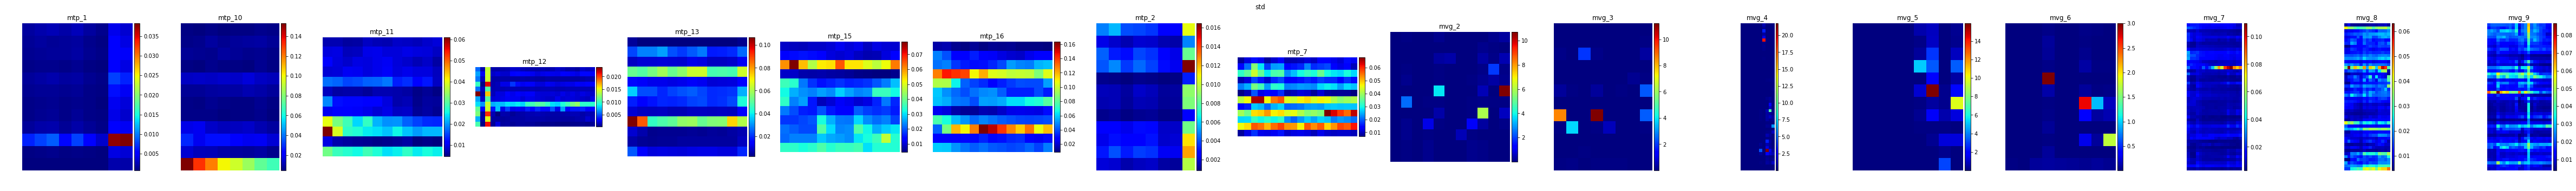

mtp_1 -8.84440605335512 -3.200221926951304
mtp_10 -6.300801820148641 -1.6860285260487997
mtp_11 -6.285124032557658 -2.5189888643727225
mtp_12 -10.864297878437453 -4.0326487476420345
mtp_13 -7.214635929566997 -1.2494431429199946
mtp_15 -5.972778231408462 -2.1027383853542596
mtp_16 -4.986490292784446 -1.0249076879610173
mtp_2 -8.50592870434959 -4.300116180929061
mtp_7 -5.887059740519364 -2.314356793478113
mvg_2 -5.63592161093686 -2.216596606682916
mvg_3 -6.301222416504151 -2.5239268266459733
mvg_4 -5.941365463070148 -1.8702428747737427
mvg_5 -5.8326208777164155 -2.2430146879475164
mvg_6 -5.358634347791871 -2.10438824754473
mvg_7 -6.557748950184028 -1.6940187844246226
mvg_8 -6.054982066312067 -2.331663557567888
mvg_9 -6.206672783743482 -1.883318453729309


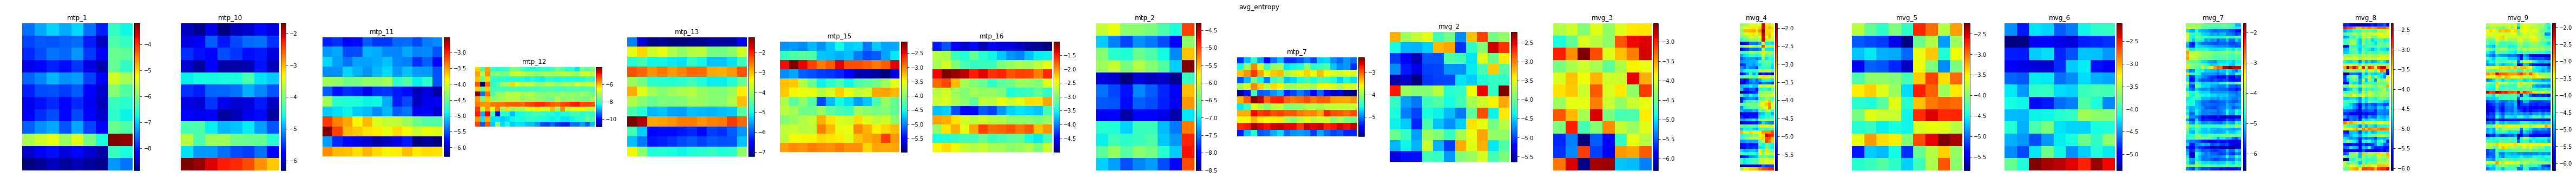

In [13]:
# def est1(data2D):
#     return np.sqrt(np.mean(data2D**2))

# def est2(data2D):
#     return np.sqrt(np.mean((data2D - np.mean(data2D))**2))

# ####################
# # Variance
# ####################

# fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(5 * len(dataDB.mice),5))
# fig.suptitle("Variance")
# for iMouse, mousename in enumerate(sorted(dataDB.mice)):
#     rows = dataDB.get_rows('neuro', {'mousename' : mousename})
    
#     rez = []
#     for idx, row in rows.iterrows(): 
#         session = row['mousekey']
#         data = dataDB.dataNeuronal[idx]

#         rezMouse = []
#         for iChannel in range(data.shape[2]):
#             dataThis = data[:, :, iChannel]

#             rezMouse += [est1(dataThis)]

#         rez += [rezMouse]
        
#     print(mousename, np.min(rez), np.max(rez))
        
#     ax[iMouse].set_title(mousename)
#     ax[iMouse].imshow(np.log10(np.array(rez).T), vmin=-4, vmax=2, cmap='jet')
# plt.show()

####################
# Entropy
####################
mc = MetricCalculator(serial=True, verbose=False)

for metricName in ['mean', 'std', 'avg_entropy']:
    fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(5 * len(dataDB.mice),5))
    fig.suptitle(metricName)
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        rows = dataDB.get_rows('neuro', {'mousename' : mousename})

        rez = []
        for idx, row in rows.iterrows(): 
            session = row['mousekey']

            mc.set_data(dataDB.dataNeuronal[idx], "rsp")
            rez += [mc.metric3D(metricName, "p")]

        print(mousename, np.min(rez), np.max(rez))
        
        imshow(fig, ax[iMouse], np.array(rez).T, xlabel='sessions', ylabel='channels', title=mousename, haveColorBar=True, cmap='jet')
    plt.show()

## 2.2 PSD-based measures

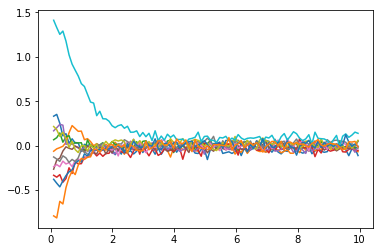

In [137]:
dataThis = dataDB.dataNeuronal[5]
# stdThis = np.std(dataThis)
nTrial, nTime, nChannel = dataThis.shape

def weirdpsd(f, psd, tau):
    return psd * (1 + (f*tau)**2)

def transfunc(dff):
    return dff / (1.5 - dff)


psdMuLst = []
for iChannel in range(nChannel):
    psdLogLst = []
    for iTrial in range(nTrial):
        dataTrial = np.copy(dataThis[iTrial, :, iChannel])# / stdThis
#         dataTrial /= np.std(dataTrial)
    #     dataTrial = np.random.normal(0, 1, nTime)
    #     dataTrial = transfunc(dataTrial)

        f, psd = periodogram(dataTrial, fs=20)
    #     psd = weirdpsd(f, psd, 0.2)
        psdLogLst += [np.log10(psd[1:])]

    f = f[1:]
    psdMu = np.mean(psdLogLst, axis=0)
#     psdStd = np.std(psdLogLst, axis=0)
    psdMuLst += [psdMu]
#     plt.fill_between(f, psdMu-psdStd, psdMu+psdStd, alpha=0.2)

psdMuAvg = np.mean(psdMuLst, axis=0)

plt.figure()
for iChannel in range(nChannel):
    plt.plot(f, psdMuLst[iChannel] - psdMuAvg)

plt.show()

# 3. Temporal Structure
## 3.1 Temporal specificity

In [14]:
pool.terminate()
pool.join()

doing mouse mtp_1
..session mtp_1_2015_06_18_b; took time 0.14505434036254883
..session mtp_1_2015_06_19_b; took time 0.14217686653137207
..session mtp_1_2015_06_22_b; took time 0.12428522109985352
..session mtp_1_2015_06_23_b; took time 0.12748241424560547
..session mtp_1_2015_06_24_a; took time 0.1436748504638672
..session mtp_1_2015_06_25_a; took time 0.1330714225769043
..session mtp_1_2015_06_26_a; took time 0.13842439651489258
..session mtp_1_2015_07_14_a; took time 0.16908812522888184
..session mtp_1_2015_07_15_a; took time 0.15747499465942383


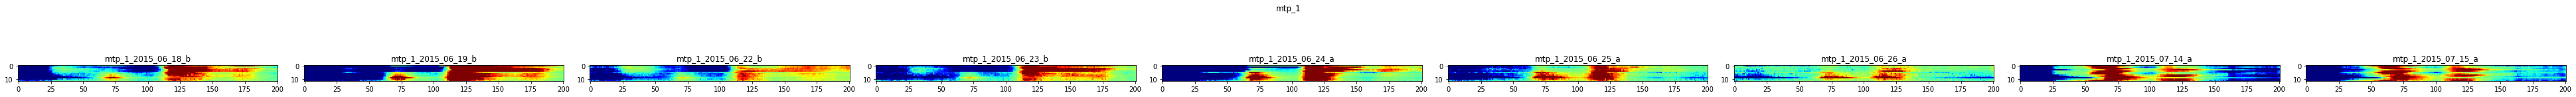

doing mouse mtp_10
..session mtp_10_2016_09_07_a; took time 0.20827507972717285
..session mtp_10_2016_09_08_b; took time 0.17131805419921875
..session mtp_10_2016_09_09_a; took time 0.16309070587158203
..session mtp_10_2016_09_12_a; took time 0.19034457206726074
..session mtp_10_2016_09_13_a; took time 0.16707134246826172
..session mtp_10_2016_09_14_a; took time 0.16853713989257812
..session mtp_10_2016_09_29_a; took time 0.18059778213500977
..session mtp_10_2016_10_04_a; took time 0.17808055877685547


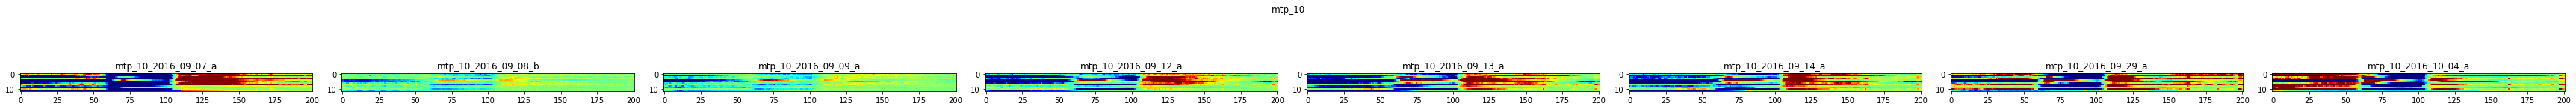

doing mouse mtp_11
..session mtp_11_2016_09_06_a; took time 0.14614295959472656
..session mtp_11_2016_09_07_a; took time 0.15221023559570312
..session mtp_11_2016_09_08_a; took time 0.15935540199279785
..session mtp_11_2016_09_09_a; took time 0.1781630516052246
..session mtp_11_2016_09_12_a; took time 0.16452717781066895
..session mtp_11_2016_09_13_a; took time 0.16862010955810547
..session mtp_11_2016_09_14_a; took time 0.1563887596130371
..session mtp_11_2016_09_27_a; took time 0.15738177299499512
..session mtp_11_2016_09_29_a; took time 0.18944787979125977
..session mtp_11_2016_10_04_a; took time 0.15180110931396484
..session mtp_11_2016_10_05_a; took time 0.15855884552001953
..session mtp_11_2016_10_11_a; took time 0.13594484329223633


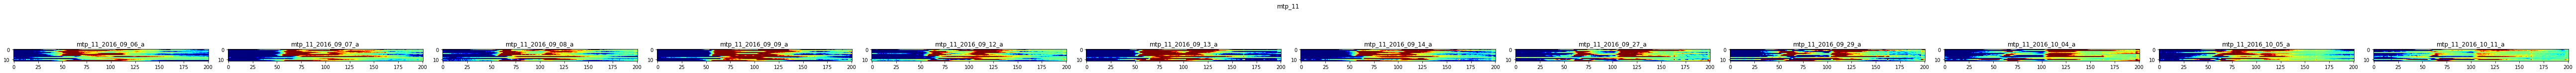

doing mouse mtp_12
..session mtp_12_2016_10_26_a; took time 0.18068432807922363
..session mtp_12_2016_11_01_a; took time 0.14996886253356934
..session mtp_12_2016_11_02_a; took time 0.13955116271972656
..session mtp_12_2016_11_02_b; took time 0.17078685760498047
..session mtp_12_2016_11_04_a; took time 0.20910143852233887
..session mtp_12_2016_11_07_a; took time 0.14232134819030762
..session mtp_12_2016_11_08_a; took time 0.1526625156402588
..session mtp_12_2016_11_23_a; took time 0.1552586555480957
..session mtp_12_2016_11_24_a; took time 0.20518779754638672
..session mtp_12_2016_11_25_a; took time 0.19870853424072266
..session mtp_12_2016_11_28_a; took time 0.1843099594116211
..session mtp_12_2016_11_29_a; took time 0.20586776733398438
..session mtp_12_2016_11_30_a; took time 0.19467973709106445
..session mtp_12_2016_12_01_a; took time 0.19786763191223145
..session mtp_12_2016_12_02_a; took time 0.17355918884277344
..session mtp_12_2016_12_05_a; took time 0.19421744346618652
..sessio

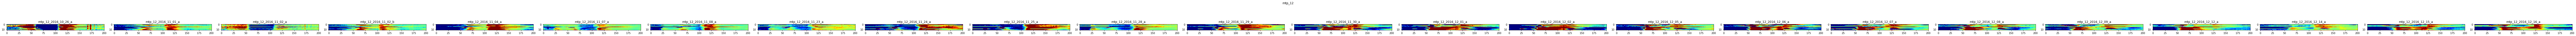

doing mouse mtp_13
..session mtp_13_2017_03_08_a; took time 0.16185450553894043
..session mtp_13_2017_03_09_a; took time 0.1883678436279297
..session mtp_13_2017_03_13_a; took time 0.1442861557006836
..session mtp_13_2017_03_14_a; took time 0.18682408332824707
..session mtp_13_2017_03_15_a; took time 0.16617846488952637
..session mtp_13_2017_03_16_a; took time 0.16894006729125977
..session mtp_13_2017_03_17_a; took time 0.18916893005371094
..session mtp_13_2017_03_20_a; took time 0.1321859359741211
..session mtp_13_2017_03_21_a; took time 0.17248845100402832
..session mtp_13_2017_03_22_a; took time 0.16457724571228027
..session mtp_13_2017_03_23_a; took time 0.19237136840820312
..session mtp_13_2017_03_24_a; took time 0.16037487983703613


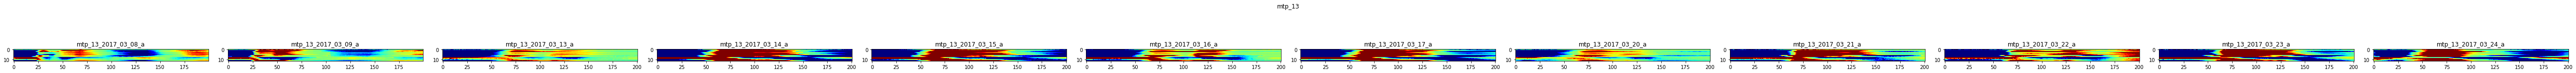

doing mouse mtp_15
..session mtp_15_2018_05_16_a; took time 0.146958589553833
..session mtp_15_2018_05_17_a; took time 0.15214276313781738
..session mtp_15_2018_05_18_a; took time 0.1578233242034912
..session mtp_15_2018_05_19_a; took time 0.13191509246826172
..session mtp_15_2018_05_22_a; took time 0.17153477668762207
..session mtp_15_2018_05_23_a; took time 0.18065929412841797
..session mtp_15_2018_05_24_a; took time 0.16401386260986328
..session mtp_15_2018_05_25_a; took time 0.1822192668914795
..session mtp_15_2018_05_29_a; took time 0.16271162033081055
..session mtp_15_2018_05_30_a; took time 0.1550133228302002
..session mtp_15_2018_05_31_a; took time 0.19873881340026855
..session mtp_15_2018_06_01_a; took time 0.1503586769104004
..session mtp_15_2018_06_04_a; took time 0.1785264015197754


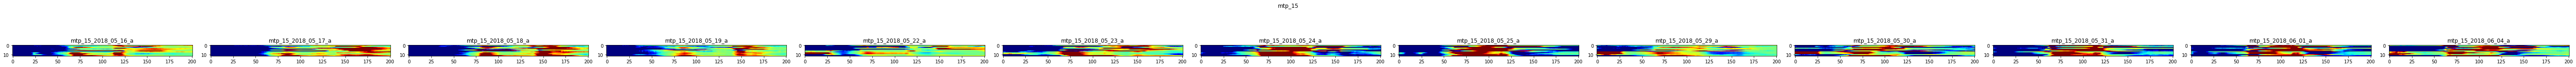

doing mouse mtp_16
..session mtp_16_2018_05_16_a; took time 0.16013455390930176
..session mtp_16_2018_05_17_a; took time 0.15920186042785645
..session mtp_16_2018_05_19_a; took time 0.18590092658996582
..session mtp_16_2018_05_20_a; took time 0.20041561126708984
..session mtp_16_2018_05_22_a; took time 0.2109999656677246
..session mtp_16_2018_05_23_a; took time 0.1726522445678711
..session mtp_16_2018_05_24_a; took time 0.21012377738952637
..session mtp_16_2018_05_25_a; took time 0.2010040283203125
..session mtp_16_2018_05_29_a; took time 0.18878865242004395
..session mtp_16_2018_05_30_a; took time 0.164872407913208
..session mtp_16_2018_05_31_a; took time 0.16215085983276367
..session mtp_16_2018_06_01_a; took time 0.19723844528198242
..session mtp_16_2018_06_04_a; took time 0.1799755096435547


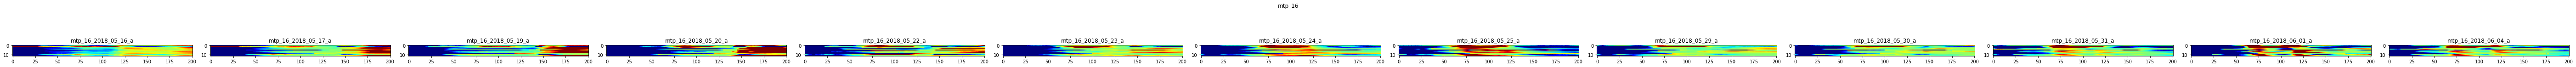

doing mouse mtp_2
..session mtp_2_2015_06_19_b; took time 0.13065767288208008
..session mtp_2_2015_06_22_b; took time 0.13825631141662598
..session mtp_2_2015_06_23_a; took time 0.1559436321258545
..session mtp_2_2015_06_23_b; took time 0.14560198783874512
..session mtp_2_2015_06_24_a; took time 0.13628458976745605
..session mtp_2_2015_06_25_a; took time 0.13915348052978516
..session mtp_2_2015_06_26_a; took time 0.12948107719421387
..session mtp_2_2015_07_13_a; took time 0.1270456314086914


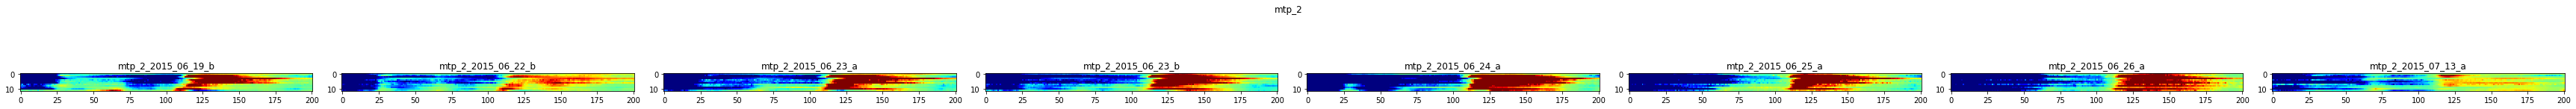

doing mouse mtp_7
..session mtp_7_2016_02_18_a; took time 0.19978713989257812
..session mtp_7_2016_02_19_a; took time 0.18255257606506348
..session mtp_7_2016_02_22_b; took time 0.16828417778015137
..session mtp_7_2016_02_23_a; took time 0.18320751190185547
..session mtp_7_2016_02_24_a; took time 0.1969316005706787
..session mtp_7_2016_02_25_a; took time 0.22043609619140625
..session mtp_7_2016_02_26_a; took time 0.2283165454864502
..session mtp_7_2016_03_01_a; took time 0.18784070014953613
..session mtp_7_2016_03_02_a; took time 0.2068474292755127
..session mtp_7_2016_03_03_a; took time 0.23068594932556152
..session mtp_7_2016_03_08_b; took time 0.20605206489562988
..session mtp_7_2016_03_09_a; took time 0.231400728225708
..session mtp_7_2016_03_11_a; took time 0.2108926773071289
..session mtp_7_2016_03_14_b; took time 0.20235323905944824
..session mtp_7_2016_03_15_a; took time 0.17467093467712402
..session mtp_7_2016_03_16_a; took time 0.16552257537841797
..session mtp_7_2016_03_17_a

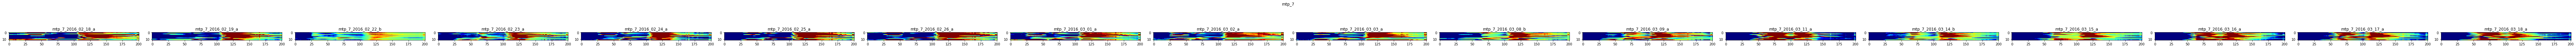

doing mouse mvg_2
..session mvg_2_2017_08_29_a; took time 0.13256001472473145
..session mvg_2_2017_08_31_a; took time 0.1717088222503662
..session mvg_2_2017_09_01_a; took time 0.1749281883239746
..session mvg_2_2017_09_04_a; took time 0.13947820663452148
..session mvg_2_2017_09_05_a; took time 0.1529090404510498
..session mvg_2_2017_09_06_a; took time 0.15421724319458008
..session mvg_2_2017_09_07_a; took time 0.1572856903076172
..session mvg_2_2017_09_08_a; took time 0.1696639060974121
..session mvg_2_2017_09_12_a; took time 0.1410377025604248
..session mvg_2_2017_09_13_a; took time 0.14600229263305664
..session mvg_2_2017_09_14_a; took time 0.15408968925476074


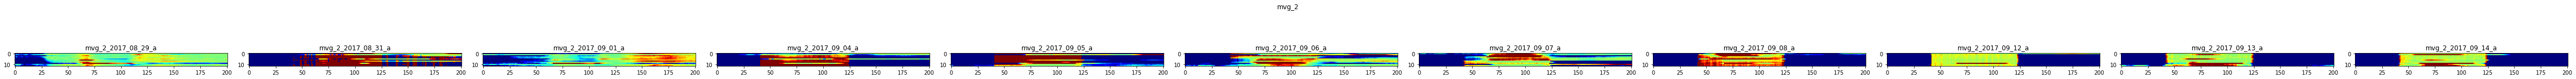

doing mouse mvg_3
..session mvg_3_2017_09_01_a; took time 0.1412646770477295
..session mvg_3_2017_09_04_a; took time 0.15595507621765137
..session mvg_3_2017_09_08_a; took time 0.13112258911132812
..session mvg_3_2017_09_12_a; took time 0.14063525199890137
..session mvg_3_2017_09_15_a; took time 0.15115642547607422
..session mvg_3_2017_09_27_a; took time 0.16312050819396973
..session mvg_3_2017_09_28_a; took time 0.1454625129699707
..session mvg_3_2017_09_29_a; took time 0.15600919723510742


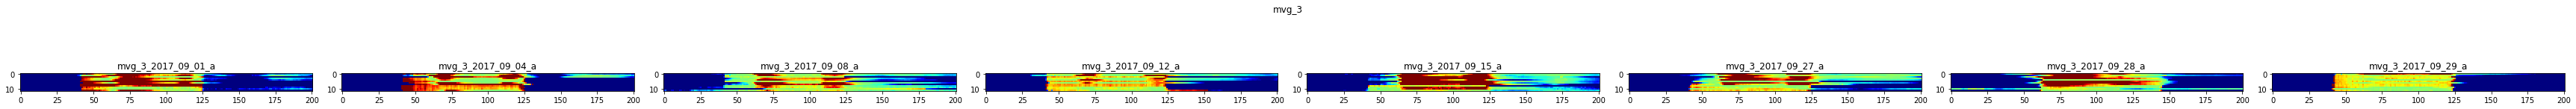

doing mouse mvg_4
..session mvg_4_2017_11_10_a; took time 0.7786567211151123
..session mvg_4_2017_11_13_a; took time 0.7399401664733887
..session mvg_4_2017_11_14_a; took time 0.7262594699859619
..session mvg_4_2017_11_15_a; took time 0.5821762084960938
..session mvg_4_2017_11_16_a; took time 0.6762058734893799
..session mvg_4_2017_11_17_a; took time 0.643303394317627
..session mvg_4_2017_11_20_a; took time 0.7058353424072266
..session mvg_4_2017_11_21_a; took time 0.6994729042053223
..session mvg_4_2017_11_22_a; took time 0.7748551368713379
..session mvg_4_2017_11_23_a; took time 0.7054955959320068
..session mvg_4_2017_11_24_a; took time 0.7137653827667236


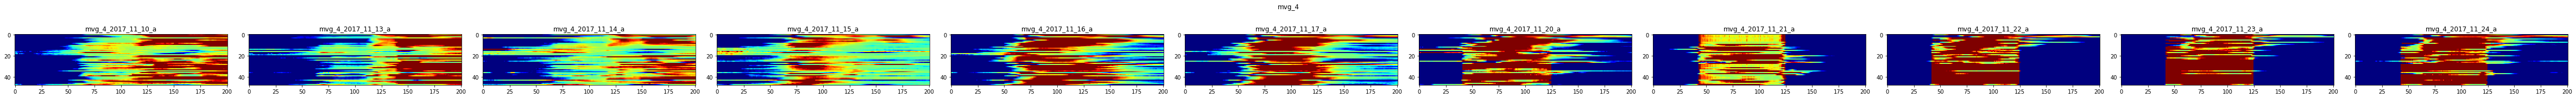

doing mouse mvg_5
..session mvg_5_2017_11_13_a; took time 0.16130352020263672
..session mvg_5_2017_11_14_a; took time 0.15008878707885742
..session mvg_5_2017_11_15_a; took time 0.17299890518188477
..session mvg_5_2017_11_16_a; took time 0.1472790241241455
..session mvg_5_2017_11_17_a; took time 0.19982123374938965
..session mvg_5_2017_11_20_a; took time 0.14008712768554688
..session mvg_5_2017_11_21_a; took time 0.1658780574798584
..session mvg_5_2017_11_22_a; took time 0.1365828514099121
..session mvg_5_2017_11_23_a; took time 0.15278315544128418


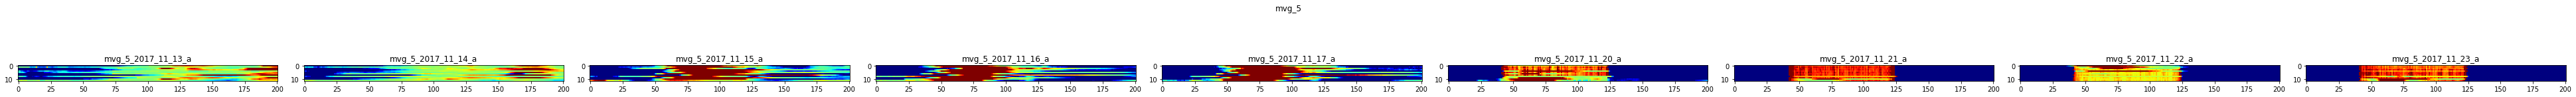

doing mouse mvg_6
..session mvg_6_2017_12_07_a; took time 0.15974950790405273
..session mvg_6_2017_12_08_a; took time 0.16037964820861816
..session mvg_6_2017_12_11_a; took time 0.12682533264160156
..session mvg_6_2017_12_12_a; took time 0.18346381187438965
..session mvg_6_2017_12_13_a; took time 0.17296290397644043
..session mvg_6_2017_12_14_a; took time 0.1761631965637207
..session mvg_6_2017_12_15_a; took time 0.1667478084564209
..session mvg_6_2017_12_18_a; took time 0.15772676467895508
..session mvg_6_2017_12_19_a; took time 0.17803096771240234


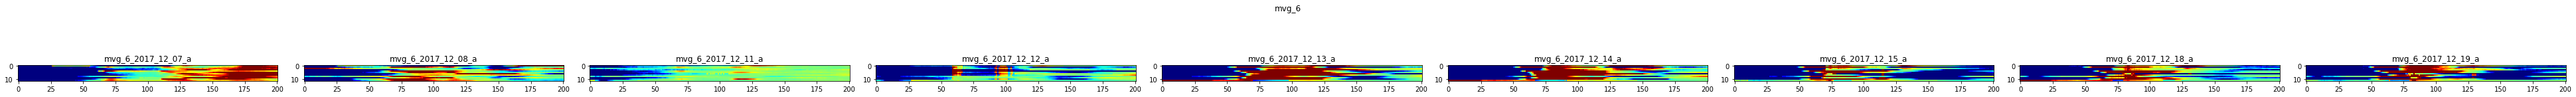

doing mouse mvg_7
..session mvg_7_2018_11_09_a; took time 0.48070693016052246
..session mvg_7_2018_11_12_a; took time 0.683037519454956
..session mvg_7_2018_11_13_a; took time 0.6972231864929199
..session mvg_7_2018_11_14_a; took time 0.6527390480041504
..session mvg_7_2018_11_15_a; took time 0.608361005783081
..session mvg_7_2018_11_17_a; took time 0.6882762908935547
..session mvg_7_2018_11_18_a; took time 0.681251049041748
..session mvg_7_2018_11_19_a; took time 0.7339940071105957
..session mvg_7_2018_11_20_a; took time 0.6800479888916016
..session mvg_7_2018_11_21_a; took time 0.7285976409912109
..session mvg_7_2018_11_22_a; took time 0.7486696243286133
..session mvg_7_2018_11_23_a; took time 0.7413902282714844
..session mvg_7_2018_11_24_a; took time 0.7379550933837891
..session mvg_7_2018_11_26_a; took time 0.5602099895477295
..session mvg_7_2018_11_28_a; took time 0.6864726543426514
..session mvg_7_2018_11_29_a; took time 0.7199649810791016
..session mvg_7_2018_12_04_a; took time 

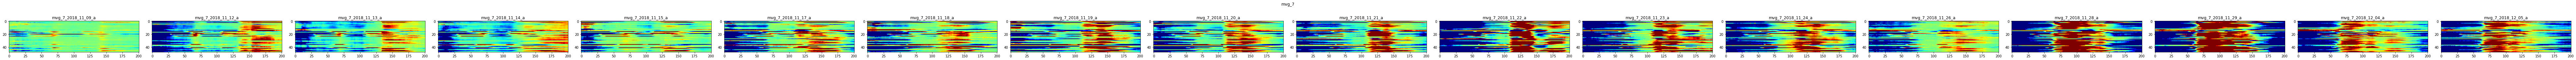

doing mouse mvg_8
..session mvg_8_2018_11_12_a; took time 0.5838005542755127
..session mvg_8_2018_11_13_a; took time 0.5588095188140869
..session mvg_8_2018_11_14_a; took time 0.722815752029419
..session mvg_8_2018_11_15_a; took time 0.847292423248291
..session mvg_8_2018_11_16_a; took time 0.7495512962341309
..session mvg_8_2018_11_17_a; took time 0.794302225112915
..session mvg_8_2018_11_18_a; took time 0.5629589557647705
..session mvg_8_2018_11_19_a; took time 0.5414080619812012
..session mvg_8_2018_11_20_a; took time 0.5956640243530273
..session mvg_8_2018_11_21_a; took time 0.5835151672363281
..session mvg_8_2018_11_23_a; took time 0.5953621864318848
..session mvg_8_2018_11_27_a; took time 0.6575932502746582
..session mvg_8_2018_11_28_a; took time 0.6403570175170898
..session mvg_8_2018_11_29_a; took time 0.6997363567352295
..session mvg_8_2018_12_04_a; took time 0.5999109745025635


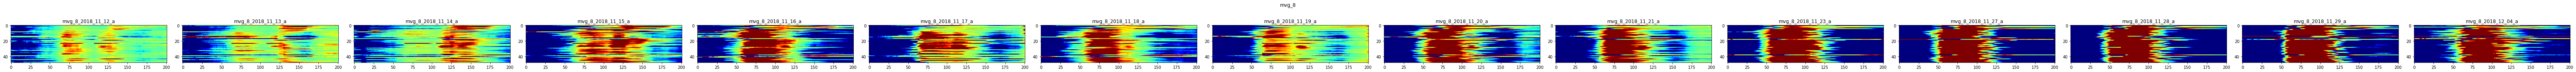

doing mouse mvg_9
..session mvg_9_2019_02_06_a; took time 0.6004416942596436
..session mvg_9_2019_02_07_a; took time 0.8156609535217285
..session mvg_9_2019_02_08_a; took time 0.6858298778533936
..session mvg_9_2019_02_12_a; took time 0.5314397811889648
..session mvg_9_2019_02_13_a; took time 0.8895606994628906
..session mvg_9_2019_02_14_a; took time 0.749253511428833
..session mvg_9_2019_02_18_a; took time 0.772716760635376
..session mvg_9_2019_02_19_a; took time 0.7784583568572998
..session mvg_9_2019_02_20_a; took time 0.856971263885498
..session mvg_9_2019_02_21_a; took time 0.9891238212585449
..session mvg_9_2019_02_23_a; took time 0.8108775615692139
..session mvg_9_2019_02_24_a; took time 0.8510026931762695
..session mvg_9_2019_02_25_a; took time 0.8945972919464111
..session mvg_9_2019_02_26_a; took time 1.0041401386260986
..session mvg_9_2019_02_27_a; took time 0.7581930160522461
..session mvg_9_2019_03_04_a; took time 0.8686764240264893
..session mvg_9_2019_03_05_a; took time 0

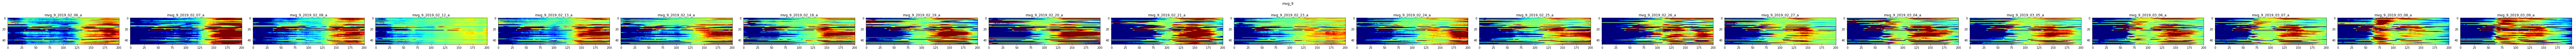

In [17]:
import multiprocessing
from time import time

def task2(data2D):
    dataTmp = data2D - np.mean(data2D)
    
    nTime = data2D.shape[1]
    rez = np.zeros(nTime)

    for iTime in range(nTime):
        T, pval = wilcoxon(dataTmp[:, iTime])
#         rez[iTime] = np.sign(np.mean(dataTmp[:, iTime])) * int(pval < 0.01 / nTime)
        rez[iTime] = np.sign(np.mean(dataTmp[:, iTime])) * (-np.log10(pval))
    return rez
    

# Parallel stuff
pool = multiprocessing.Pool(processes=4)

for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    print('doing mouse', mousename)
    rows = dataDB.get_rows('neuro', {'mousename' : mousename})
    
    fig, ax = plt.subplots(ncols=len(rows), figsize=(6*len(rows), 3), tight_layout=True)
    fig.suptitle(mousename)
    
    for iPlot, (idx, row) in enumerate(rows.iterrows()):
        session = row['mousekey']
        print('..session', session, end='')
        timeStart = time()

        data = dataDB.dataNeuronal[idx]
        dataTmp = data.transpose((2,0,1))
        rez = np.array(pool.map(task2, dataTmp))

#         ax[iPlot].imshow(rez, vmin=-1.1, vmax=1.1, cmap='jet')
        ax[iPlot].imshow(rez, vmin=-10, vmax=10, cmap='jet')
        ax[iPlot].set_title(session)

        print('; took time', time() - timeStart)
    plt.show()
    
pool.terminate()
pool.join()

# 4. Behaviour-Specific performance

## 4.1 Temporal mean vs learning

doing mouse mtp_1
doing mouse mtp_10
doing mouse mtp_11
doing mouse mtp_12
doing mouse mtp_13
doing mouse mtp_15
doing mouse mtp_16
doing mouse mtp_2
doing mouse mtp_7
doing mouse mvg_2
doing mouse mvg_3
doing mouse mvg_4
doing mouse mvg_5
doing mouse mvg_6
doing mouse mvg_7
doing mouse mvg_8
doing mouse mvg_9


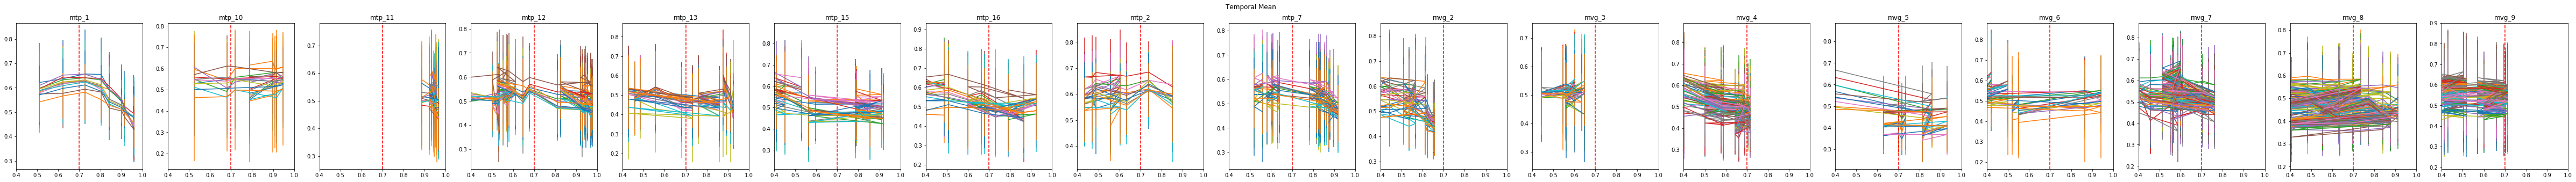

In [8]:
mc = MetricCalculator(serial=True, verbose=False)

fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(5 * len(dataDB.mice),5))
fig.suptitle("Temporal Mean")
for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    print('doing mouse', mousename)
    rows = dataDB.get_rows('neuro', {'mousename' : mousename})
    
    rezPerformance = []
    rezMean = []
    rezStd = []
    for idx, row in rows.iterrows():
        mc.set_data(dataDB.dataNeuronal[idx], 'rsp', zscoreDim=None)
        rezThis = mc.metric3D('ord_mean', 'pr', metricSettings={'stdFilter' : None}, sweepSettings=None)
        
        rezPerformance += [dataDB.dataPerformance[idx]]
        rezMean += [np.mean(rezThis, axis=1)]
        rezStd += [np.std(rezThis, axis=1)]
        
    rezMean = np.array(rezMean).T
    rezStd = np.array(rezStd).T
    
    for iChannel, (mean, std) in enumerate(zip(rezMean, rezStd)):
        ax[iMouse].errorbar(rezPerformance, mean, std)
    
    ax[iMouse].set_xlim([0.4, 1])
    ax[iMouse].axvline(x=0.7, color='r', linestyle='--')
    ax[iMouse].set_title(mousename)
plt.show()